In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

In [2]:
np.random.seed(20)

In [3]:
# load the LFW data (Check the loading function and provide appropriate parameters)
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

x = lfw_people.data
y = lfw_people.target
images = lfw_people.images
names = lfw_people.target_names

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

num_classes = max(y) + 1

In [4]:
# Define how many images you want to display
n_images = 6

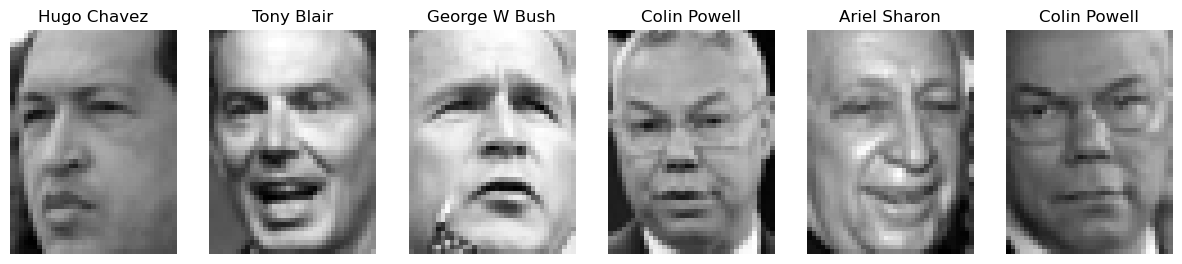

In [5]:
# Create a grid plot with matplotlib
fig, ax = plt.subplots(1, n_images, figsize=(15, 10))
for i in range(n_images):
    ax[i].imshow(images[i], cmap='gray')  # Display images in grayscale
    ax[i].set_title(names[y[i]])  # Set the title to the person's name
    ax[i].axis('off')  # Turn off axis numbering
plt.show()

In [6]:
def plot_images(original, reconstructed, num_images):
    """
    Plot original and reconstructed images side by side for comparison.

    Args:
        original (numpy.ndarray): Array of original images, each flattened to a 1D vector.
        reconstructed (numpy.ndarray): Array of reconstructed images, each flattened to a 1D vector.
        num_images (int): Number of images to display.

    Returns:
        None: Displays the plots of original and reconstructed images.
    """
    plt.figure(figsize=(10, 2 * num_images))
    for i in range(num_images):
        # Plot the original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original[i].reshape(50, 37), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot the reconstructed image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(reconstructed[i].reshape(50, 37), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
class RestrictedBoltzmannMachine:
    """
    A class representing a Restricted Boltzmann Machine (RBM), which is a generative stochastic neural network
    that can learn a probability distribution over its set of inputs.

    Attributes:
        num_visible (int): Number of visible units.
        num_hidden (int): Number of hidden units.
        weights (numpy.ndarray): Weight matrix of shape (num_visible, num_hidden).
        visible_bias (numpy.ndarray): Bias vector for visible units of shape (num_visible,).
        hidden_bias (numpy.ndarray): Bias vector for hidden units of shape (num_hidden,).
    """

    def __init__(self, num_visible, num_hidden):
        """
        Initialize the RBM with the specified number of visible and hidden units.

        Args:
            num_visible (int): Number of visible units (e.g., features of the input data).
            num_hidden (int): Number of hidden units (e.g., the size of the latent representation).
        """
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = np.random.normal(0, 0.1, size=(num_visible, num_hidden))  # Initialize weights randomly.
        self.visible_bias = np.zeros(num_visible)  # Initialize visible unit biases to zero.
        self.hidden_bias = np.zeros(num_hidden)  # Initialize hidden unit biases to zero.

    @staticmethod
    def sigmoid(x):
        """
        Compute the sigmoid function.

        Args:
            x (numpy.ndarray): Input array.

        Returns:
            numpy.ndarray: Sigmoid of the input.
        """
        return 1 / (1 + np.exp(-x))

    def contrastive_divergence(self, batch, learning_rate):
        """
        Perform one step of the Contrastive Divergence (CD) algorithm to update weights and biases.

        Args:
            batch (numpy.ndarray): Batch of input data of shape (batch_size, num_visible).
            learning_rate (float): Learning rate for updating weights and biases.

        Returns:
            float: Mean squared error between the input data and its reconstruction.
        """
        # Positive phase: compute probabilities and associations
        positive_hidden_probabilities = self.sigmoid(np.dot(batch, self.weights) + self.hidden_bias)
        positive_hidden_states = (positive_hidden_probabilities > np.random.rand(*positive_hidden_probabilities.shape)).astype(np.float64)
        positive_associations = np.dot(batch.T, positive_hidden_probabilities)

        # Negative phase: reconstruct visible probabilities and recompute hidden probabilities
        negative_visible_probabilities = self.sigmoid(np.dot(positive_hidden_states, self.weights.T) + self.visible_bias)
        negative_hidden_probabilities = self.sigmoid(np.dot(negative_visible_probabilities, self.weights) + self.hidden_bias)
        negative_associations = np.dot(negative_visible_probabilities.T, negative_hidden_probabilities)

        # Update weights and biases
        self.weights += learning_rate * (positive_associations - negative_associations) / batch.shape[0]
        self.visible_bias += learning_rate * np.mean(batch - negative_visible_probabilities, axis=0)
        self.hidden_bias += learning_rate * np.mean(positive_hidden_probabilities - negative_hidden_probabilities, axis=0)

        # Calculate reconstruction error
        error = np.mean(np.square(batch - negative_visible_probabilities))
        return error

    def extract(self, data):
        """
        Compute the hidden unit probabilities for the input data.

        Args:
            data (numpy.ndarray): Input data of shape (num_samples, num_visible).

        Returns:
            numpy.ndarray: Probabilities of the hidden units of shape (num_samples, num_hidden).
        """
        hidden_probabilities = self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        return hidden_probabilities

    def reconstruct(self, data):
        """
        Reconstruct the visible units from the input data.

        Args:
            data (numpy.ndarray): Input data of shape (num_samples, num_visible).

        Returns:
            numpy.ndarray: Reconstructed visible unit probabilities of shape (num_samples, num_visible).
        """
        hidden_probabilities = self.extract(data)  # Compute hidden probabilities
        hidden_states = (hidden_probabilities > 0.5).astype(np.float64)  # Binarize hidden states
        visible_probabilities = self.sigmoid(np.dot(hidden_states, self.weights.T) + self.visible_bias)  # Reconstruct
        return visible_probabilities

    def train(self, data, learning_rate=1e-2, num_epochs=5000, batch_size=32):
        """
        Train the RBM using Contrastive Divergence.

        Args:
            data (numpy.ndarray): Training data of shape (num_samples, num_visible).
            learning_rate (float): Learning rate for weight updates.
            num_epochs (int): Number of training epochs.
            batch_size (int): Size of each mini-batch.

        Returns:
            list: Average reconstruction error for each epoch.
        """
        total_avg_error = []

        for epoch in range(num_epochs):
            np.random.shuffle(data)  # Shuffle data at each epoch
            total_batches = 0
            total_error = 0

            # Process mini-batches
            for i in range(0, data.shape[0], batch_size):
                batch = data[i:i + batch_size]
                total_batches += 1
                total_error += self.contrastive_divergence(batch, learning_rate)

            avg_error = total_error / total_batches  # Compute average error
            total_avg_error.append(avg_error)

            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}, Average Reconstruction Error: {avg_error}')

            # Dynamically visualize reconstructions every 1000 epochs
            if (epoch + 1) % 1000 == 0:
                sample_reconstructed = self.reconstruct(data[:n_images])  # Reconstruct first 5 samples
                plot_images(data[:n_images], sample_reconstructed, n_images)  # Plot original and reconstructed samples

        return total_avg_error


In [8]:
# Initialize and train the RBM model
num_visible = x_train.shape[1]
num_hidden = 256
rbm = RestrictedBoltzmannMachine(num_visible, num_hidden)

Epoch 100, Average Reconstruction Error: 0.015760736616395772
Epoch 200, Average Reconstruction Error: 0.014145872354773633
Epoch 300, Average Reconstruction Error: 0.013388765948304324
Epoch 400, Average Reconstruction Error: 0.013139935450847955
Epoch 500, Average Reconstruction Error: 0.012879618651240068
Epoch 600, Average Reconstruction Error: 0.012435703464987184
Epoch 700, Average Reconstruction Error: 0.0124644778449767
Epoch 800, Average Reconstruction Error: 0.012234708524128661
Epoch 900, Average Reconstruction Error: 0.012033400252900879
Epoch 1000, Average Reconstruction Error: 0.011869380425451631


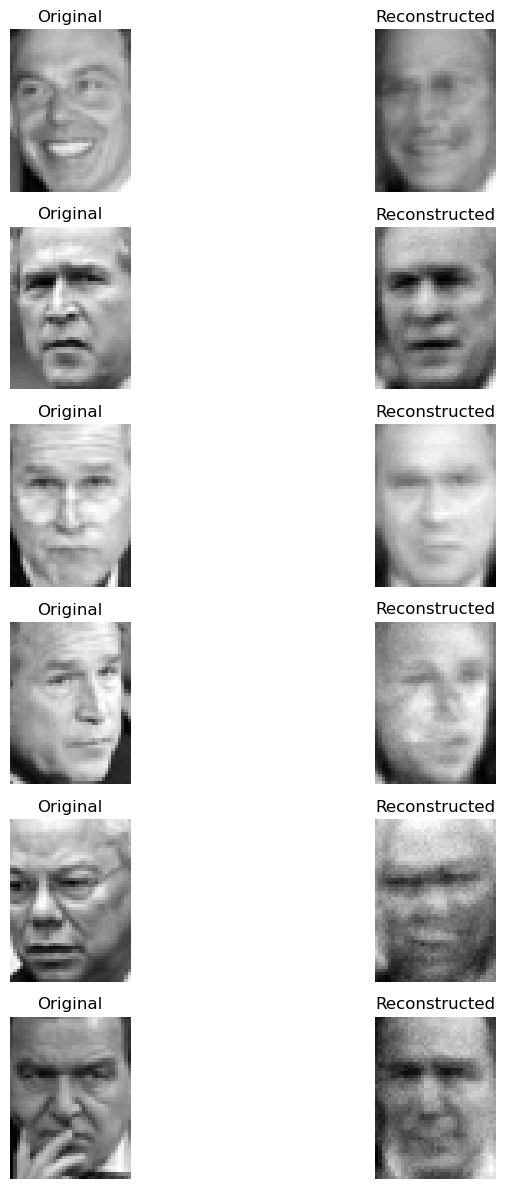

Epoch 1100, Average Reconstruction Error: 0.011770025200911713
Epoch 1200, Average Reconstruction Error: 0.011643155175156376
Epoch 1300, Average Reconstruction Error: 0.011560351417364563
Epoch 1400, Average Reconstruction Error: 0.01139139514364086
Epoch 1500, Average Reconstruction Error: 0.011344354848696482
Epoch 1600, Average Reconstruction Error: 0.011310995959913344
Epoch 1700, Average Reconstruction Error: 0.011125774803339707
Epoch 1800, Average Reconstruction Error: 0.01100881773166114
Epoch 1900, Average Reconstruction Error: 0.011012802922485541
Epoch 2000, Average Reconstruction Error: 0.01081792427195383


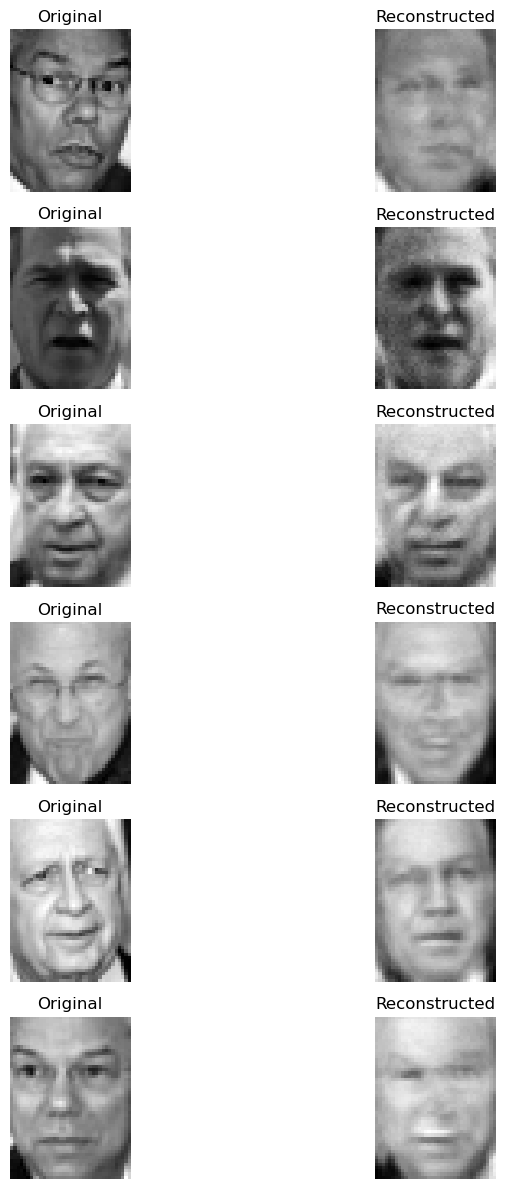

Epoch 2100, Average Reconstruction Error: 0.010704617800579807
Epoch 2200, Average Reconstruction Error: 0.010582100118381814
Epoch 2300, Average Reconstruction Error: 0.010419172319293351
Epoch 2400, Average Reconstruction Error: 0.010283189465043774
Epoch 2500, Average Reconstruction Error: 0.010186170691304777
Epoch 2600, Average Reconstruction Error: 0.010021187174224072
Epoch 2700, Average Reconstruction Error: 0.009840179854985606
Epoch 2800, Average Reconstruction Error: 0.009715115842369695
Epoch 2900, Average Reconstruction Error: 0.009550800198188339
Epoch 3000, Average Reconstruction Error: 0.009250586732676432


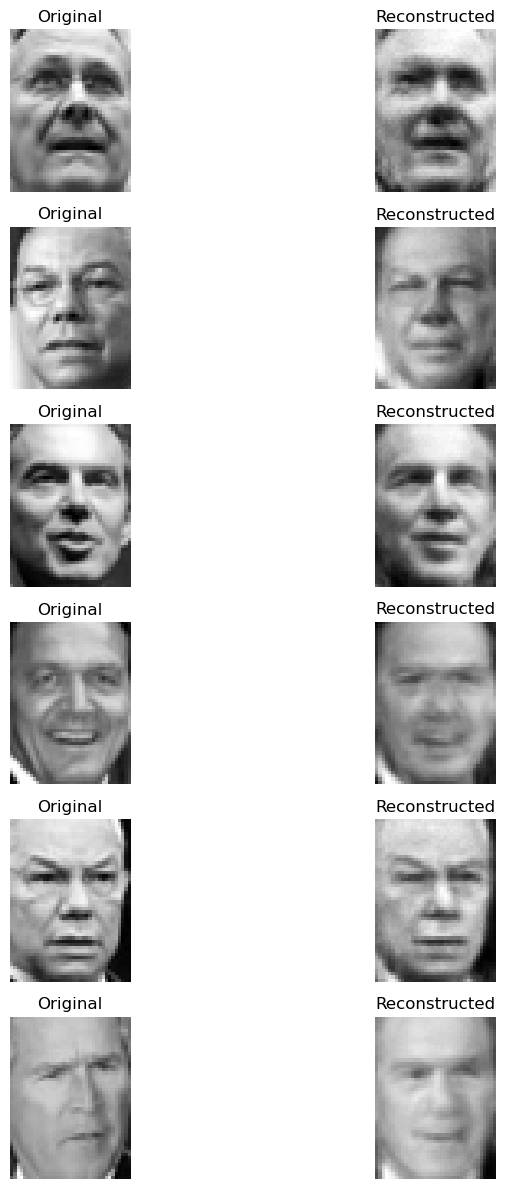

Epoch 3100, Average Reconstruction Error: 0.009046345986762724
Epoch 3200, Average Reconstruction Error: 0.008921000753100745
Epoch 3300, Average Reconstruction Error: 0.008763094009758542
Epoch 3400, Average Reconstruction Error: 0.008632489308237196
Epoch 3500, Average Reconstruction Error: 0.008427860515317095
Epoch 3600, Average Reconstruction Error: 0.008291596830922315
Epoch 3700, Average Reconstruction Error: 0.008162328157871004
Epoch 3800, Average Reconstruction Error: 0.008074487220412933
Epoch 3900, Average Reconstruction Error: 0.007940076173067257
Epoch 4000, Average Reconstruction Error: 0.007849781654279391


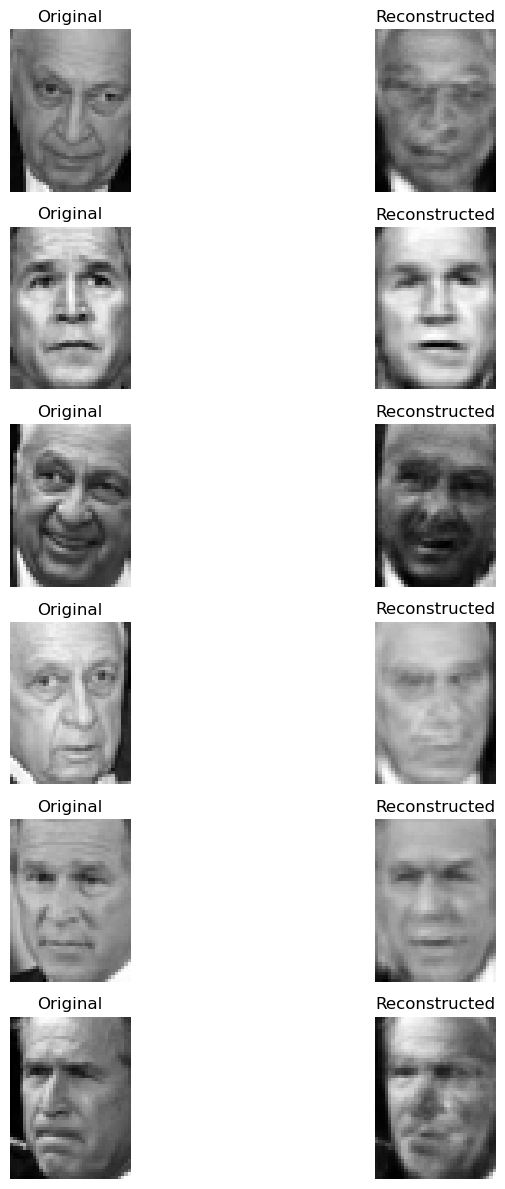

Epoch 4100, Average Reconstruction Error: 0.007816731320361031
Epoch 4200, Average Reconstruction Error: 0.007836504263082128
Epoch 4300, Average Reconstruction Error: 0.0077209948639821195
Epoch 4400, Average Reconstruction Error: 0.007623271233894206
Epoch 4500, Average Reconstruction Error: 0.0075619265053548145
Epoch 4600, Average Reconstruction Error: 0.007548649542156089
Epoch 4700, Average Reconstruction Error: 0.0075251393244069225
Epoch 4800, Average Reconstruction Error: 0.00739823221428421
Epoch 4900, Average Reconstruction Error: 0.007413927127687555
Epoch 5000, Average Reconstruction Error: 0.007388213176477406


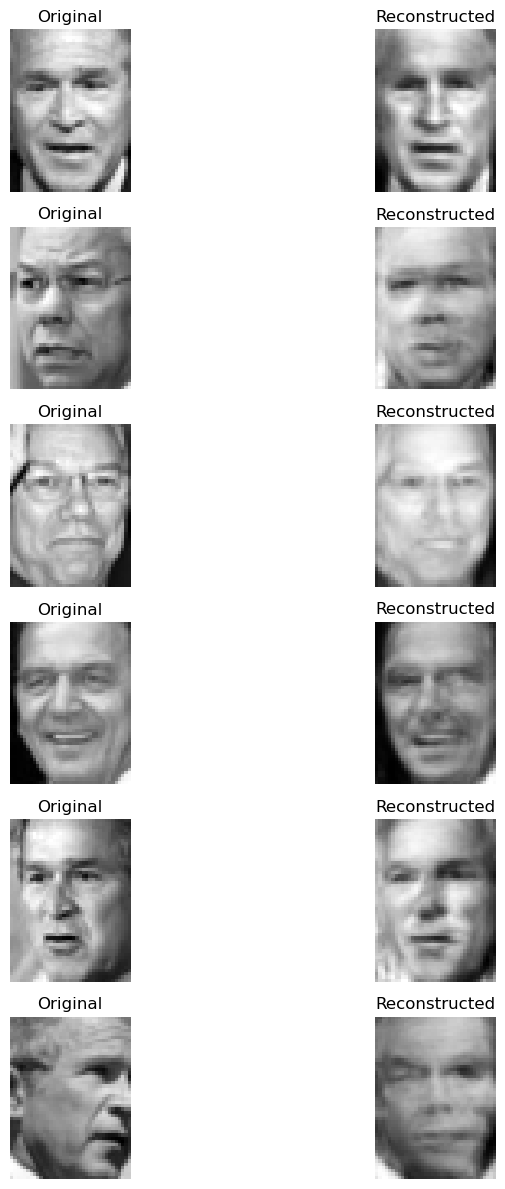

In [9]:
total_avg_error = rbm.train(x_train, learning_rate=1e-2, num_epochs=5000, batch_size=32)

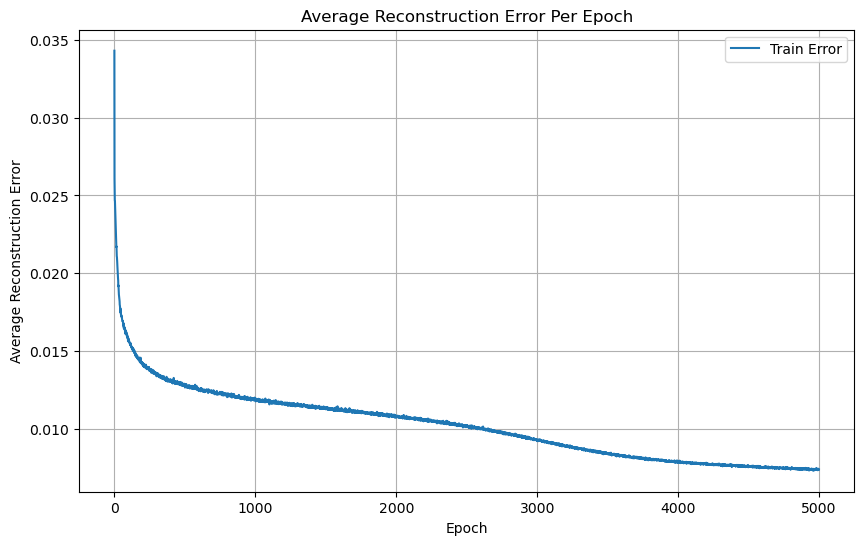

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(total_avg_error, label='Train Error')
plt.title('Average Reconstruction Error Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()

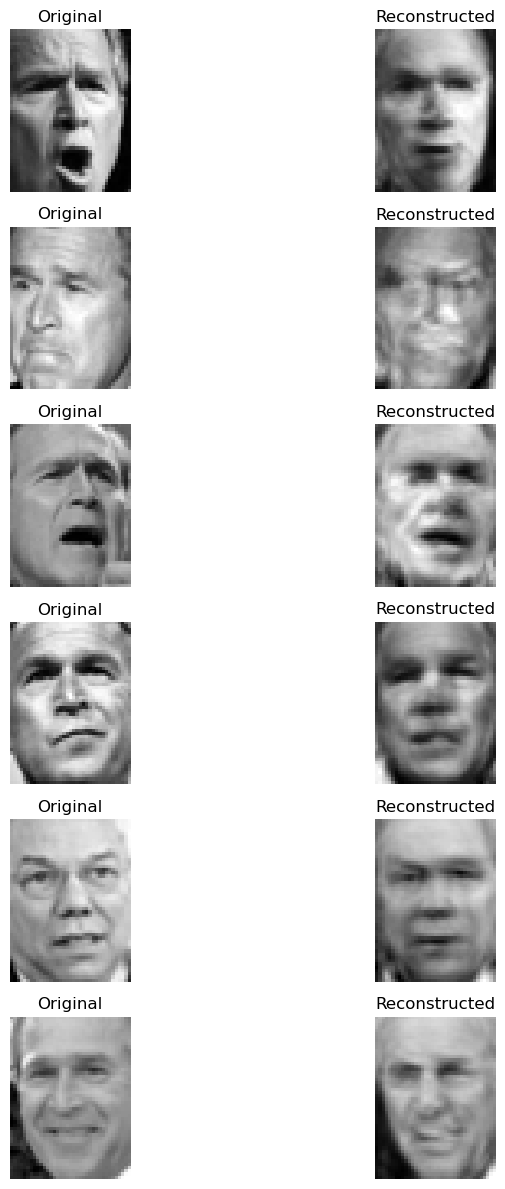

In [11]:
# Plot the sampe reconstructed by the trained model
num_plot = n_images
test_data = x_test[:num_plot]  # First [num_plot] images
reconstructed_data = rbm.reconstruct(test_data)

plot_images(test_data, reconstructed_data, num_images=num_plot)

In [12]:
train_features = rbm.extract(x_train)
test_features = rbm.extract(x_test)

In [13]:
class CustomMLPClassifier:
    """
    A simple implementation of a Multilayer Perceptron (MLP) classifier with one hidden layer.

    Attributes:
        input_size (int): Number of input features.
        hidden_size (int): Number of hidden layer units.
        output_size (int): Number of output classes.
        learning_rate (float): Learning rate for gradient descent.
        weights_input_hidden (numpy.ndarray): Weights between the input and hidden layer.
        bias_hidden (numpy.ndarray): Bias for the hidden layer.
        weights_hidden_output (numpy.ndarray): Weights between the hidden and output layer.
        bias_output (numpy.ndarray): Bias for the output layer.
        hidden_input (numpy.ndarray): Input to the hidden layer during forward pass.
        hidden_output (numpy.ndarray): Output from the hidden layer during forward pass.
        output_input (numpy.ndarray): Input to the output layer during forward pass.
        output (numpy.ndarray): Output probabilities from the model during forward pass.
    """

    def __init__(self, input_size, hidden_size, output_size, learning_rate=1e-2):
        """
        Initialize the MLP classifier with specified sizes for input, hidden, and output layers.

        Args:
            input_size (int): Number of input features.
            hidden_size (int): Number of hidden layer units.
            output_size (int): Number of output classes.
            learning_rate (float, optional): Learning rate for gradient descent. Default is 0.01.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros(hidden_size)
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros(output_size)

        # Placeholders for forward pass values
        self.hidden_input = None
        self.hidden_output = None
        self.output_input = None
        self.output = None

    @staticmethod
    def relu(x):
        """
        Compute the ReLU activation function.

        Args:
            x (numpy.ndarray): Input array.

        Returns:
            numpy.ndarray: Output after applying ReLU activation.
        """
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        """
        Compute the derivative of the ReLU function.

        Args:
            x (numpy.ndarray): Input array.

        Returns:
            numpy.ndarray: Derivative of ReLU function.
        """
        return (x > 0).astype(float)

    @staticmethod
    def softmax(x):
        """
        Compute the softmax function.

        Args:
            x (numpy.ndarray): Input array.

        Returns:
            numpy.ndarray: Probabilities after applying softmax.
        """
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def cross_entropy_loss(y_true, y_pred):
        """
        Compute the cross-entropy loss.

        Args:
            y_true (numpy.ndarray): True class labels (one-hot encoded).
            y_pred (numpy.ndarray): Predicted probabilities from the model.

        Returns:
            float: Cross-entropy loss value.
        """
        n_samples = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(n_samples), y_true])
        return np.mean(log_likelihood)

    def forward(self, x):
        """
        Perform the forward pass through the network.

        Args:
            x (numpy.ndarray): Input data of shape (num_samples, input_size).

        Returns:
            numpy.ndarray: Predicted probabilities for each class.
        """
        self.hidden_input = np.dot(x, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.relu(self.hidden_input)

        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.output = self.softmax(self.output_input)

        return self.output

    def backward(self, x, y_true):
        """
        Perform the backward pass and update weights and biases.

        Args:
            x (numpy.ndarray): Input data of shape (num_samples, input_size).
            y_true (numpy.ndarray): True class labels (integer indices).
        """
        n_samples = x.shape[0]

        # Compute output layer error
        output_error = self.output
        output_error[range(n_samples), y_true] -= 1
        output_error /= n_samples

        # Gradients for hidden-to-output weights and biases
        grad_weights_hidden_output = np.dot(self.hidden_output.T, output_error)
        grad_bias_output = np.sum(output_error, axis=0)

        # Compute hidden layer error
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * self.relu_derivative(self.hidden_input)

        # Gradients for input-to-hidden weights and biases
        grad_weights_input_hidden = np.dot(x.T, hidden_error)
        grad_bias_hidden = np.sum(hidden_error, axis=0)

        # Update weights and biases
        self.weights_hidden_output -= self.learning_rate * grad_weights_hidden_output
        self.bias_output -= self.learning_rate * grad_bias_output
        self.weights_input_hidden -= self.learning_rate * grad_weights_input_hidden
        self.bias_hidden -= self.learning_rate * grad_bias_hidden

    def fit(self, x, y, epochs=5000):
        """
        Train the MLP using gradient descent.

        Args:
            x (numpy.ndarray): Training data of shape (num_samples, input_size).
            y (numpy.ndarray): True class labels (integer indices).
            epochs (int, optional): Number of training iterations. Default is 1000.

        Returns:
            list: Loss values for each epoch.
        """
        total_loss = []

        for epoch in range(epochs):
            y_pred = self.forward(x)

            loss = self.cross_entropy_loss(y, y_pred)
            total_loss.append(loss)

            self.backward(x, y)

            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}')

        return total_loss

    def predict(self, x):
        """
        Predict class labels for the given input data.

        Args:
            x (numpy.ndarray): Input data of shape (num_samples, input_size).

        Returns:
            numpy.ndarray: Predicted class labels (integer indices).
        """
        y_pred = self.forward(x)
        return np.argmax(y_pred, axis=1)

In [14]:
mlp = CustomMLPClassifier(input_size=num_hidden, hidden_size=128, output_size=num_classes, learning_rate=1e-2)
total_loss = mlp.fit(train_features, y_train, epochs=5000)
mlp_predictions = mlp.predict(test_features)

Epoch 100/5000, Loss: 1.7463182424460122
Epoch 200/5000, Loss: 1.685091988519205
Epoch 300/5000, Loss: 1.6819075468119775
Epoch 400/5000, Loss: 1.6808859750526681
Epoch 500/5000, Loss: 1.6801983529921196
Epoch 600/5000, Loss: 1.6795940295075127
Epoch 700/5000, Loss: 1.679027367826487
Epoch 800/5000, Loss: 1.6784782099212843
Epoch 900/5000, Loss: 1.6779379002750994
Epoch 1000/5000, Loss: 1.677397460338334
Epoch 1100/5000, Loss: 1.6768504628352687
Epoch 1200/5000, Loss: 1.6762960361618964
Epoch 1300/5000, Loss: 1.6757281406628395
Epoch 1400/5000, Loss: 1.6751425096316832
Epoch 1500/5000, Loss: 1.674537584029167
Epoch 1600/5000, Loss: 1.6739121510810056
Epoch 1700/5000, Loss: 1.6732618405192097
Epoch 1800/5000, Loss: 1.672583061733433
Epoch 1900/5000, Loss: 1.6718751072914648
Epoch 2000/5000, Loss: 1.6711345592712108
Epoch 2100/5000, Loss: 1.670359338455593
Epoch 2200/5000, Loss: 1.6695476271944198
Epoch 2300/5000, Loss: 1.668698742283062
Epoch 2400/5000, Loss: 1.6678115854288453
Epoch 25

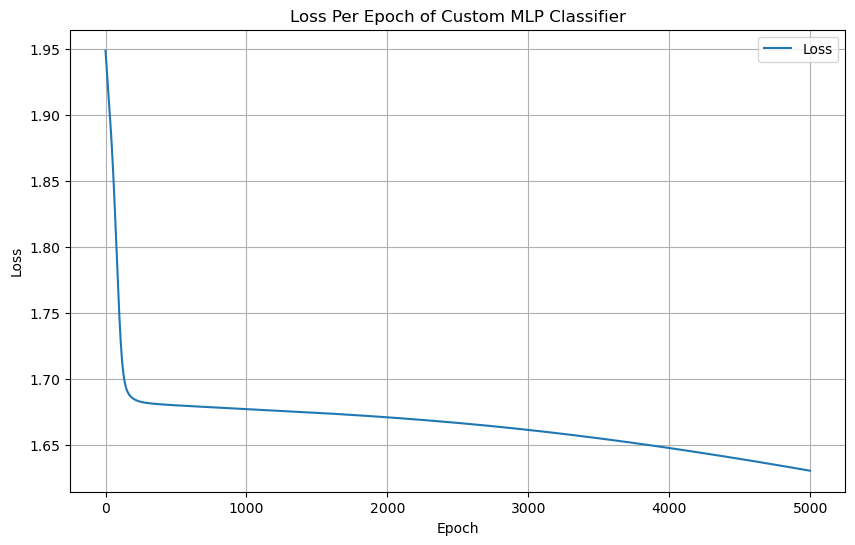

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(total_loss, label='Loss')
plt.title('Loss Per Epoch of Custom MLP Classifier')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print(f'Accuracy: {accuracy_score(y_test, mlp_predictions)}\n')
print(classification_report(y_test, mlp_predictions, target_names=names, zero_division=0))

Accuracy: 0.4108527131782946

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00         8
     Colin Powell       0.00      0.00      0.00        24
  Donald Rumsfeld       0.00      0.00      0.00        12
    George W Bush       0.41      1.00      0.58        53
Gerhard Schroeder       0.00      0.00      0.00        11
      Hugo Chavez       0.00      0.00      0.00         7
       Tony Blair       0.00      0.00      0.00        14

         accuracy                           0.41       129
        macro avg       0.06      0.14      0.08       129
     weighted avg       0.17      0.41      0.24       129



In [17]:
class CustomSVM:
    """
    A custom implementation of a Support Vector Machine (SVM) using gradient descent optimization.

    Attributes:
        input_size (int): Number of input features.
        learning_rate (float): Learning rate for gradient descent.
        lambda_param (float): Regularization parameter to prevent overfitting.
        num_epochs (int): Number of training epochs.
        weights (numpy.ndarray): Weight matrix for the model.
        bias (numpy.ndarray): Bias vector for the model.
    """

    def __init__(self, input_size, learning_rate=1e-2, lambda_param=1e-2, num_epochs=1000):
        """
        Initialize the Custom SVM with specified parameters.

        Args:
            input_size (int): Number of input features.
            learning_rate (float, optional): Learning rate for weight updates. Default is 0.01.
            lambda_param (float, optional): Regularization parameter. Default is 0.01.
            num_epochs (int, optional): Number of training epochs. Default is 1000.
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.num_epochs = num_epochs

        # Placeholders for fit pass values
        self.weights = None
        self.bias = None

    def fit(self, x, y):
        """
        Train the SVM model using gradient descent.

        Args:
            x (numpy.ndarray): Training data of shape (num_samples, input_size).
            y (numpy.ndarray): True class labels (integer indices) of shape (num_samples,).

        Returns:
            list: Loss values for each epoch.
        """
        num_samples, input_size = x.shape
        n_classes = len(np.unique(y))

        # Initialize weights and biases
        self.weights = np.zeros((input_size, n_classes))
        self.bias = np.zeros(n_classes)

        # Convert labels to one-hot encoding
        y_onehot = np.zeros((num_samples, n_classes))
        y_onehot[np.arange(num_samples), y] = 1

        total_loss = []

        for epoch in range(self.num_epochs):
            # Compute scores and probabilities
            scores = np.dot(x, self.weights) + self.bias
            probabilities = self.softmax(scores)

            # Compute loss (cross-entropy loss + regularization)
            loss = -np.sum(y_onehot * np.log(probabilities + 1e-12)) / num_samples
            loss += self.lambda_param * np.sum(self.weights ** 2)
            total_loss.append(loss)

            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}/{self.num_epochs}, Loss: {loss}')

            # Compute gradients
            grad_scores = probabilities - y_onehot
            grad_weights = np.dot(x.T, grad_scores) / num_samples + 2 * self.lambda_param * self.weights
            grad_bias = np.sum(grad_scores, axis=0) / num_samples

            # Update weights and biases
            self.weights -= self.learning_rate * grad_weights
            self.bias -= self.learning_rate * grad_bias

        return total_loss

    def predict(self, x):
        """
        Predict class labels for the given input data.

        Args:
            x (numpy.ndarray): Input data of shape (num_samples, input_size).

        Returns:
            numpy.ndarray: Predicted class labels (integer indices) of shape (num_samples,).
        """
        scores = np.dot(x, self.weights) + self.bias
        return np.argmax(scores, axis=1)

    @staticmethod
    def softmax(x):
        """
        Compute the softmax function.

        Args:
            x (numpy.ndarray): Input array of shape (num_samples, n_classes).

        Returns:
            numpy.ndarray: Probabilities after applying softmax, of shape (num_samples, n_classes).
        """
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [18]:
svm = CustomSVM(input_size=num_hidden, learning_rate=1e-2, lambda_param=1e-2, num_epochs=5000)
total_loss = svm.fit(train_features, y_train)
y_pred = svm.predict(test_features)

Epoch 100/5000, Loss: 1.6744904154370264
Epoch 200/5000, Loss: 1.6674309843715789
Epoch 300/5000, Loss: 1.6619516901026588
Epoch 400/5000, Loss: 1.6573192050918024
Epoch 500/5000, Loss: 1.653251714490196
Epoch 600/5000, Loss: 1.6496058434389627
Epoch 700/5000, Loss: 1.6462972999426655
Epoch 800/5000, Loss: 1.6432710236283299
Epoch 900/5000, Loss: 1.640487914821795
Epoch 1000/5000, Loss: 1.6379183420013583
Epoch 1100/5000, Loss: 1.6355387318212111
Epoch 1200/5000, Loss: 1.6333296610417964
Epoch 1300/5000, Loss: 1.631274721439874
Epoch 1400/5000, Loss: 1.629359802730804
Epoch 1500/5000, Loss: 1.6275726127388181
Epoch 1600/5000, Loss: 1.6259023390107092
Epoch 1700/5000, Loss: 1.6243393991041783
Epoch 1800/5000, Loss: 1.6228752493170016
Epoch 1900/5000, Loss: 1.6215022337977862
Epoch 2000/5000, Loss: 1.6202134627681986
Epoch 2100/5000, Loss: 1.6190027125028192
Epoch 2200/5000, Loss: 1.617864342056453
Epoch 2300/5000, Loss: 1.6167932231875726
Epoch 2400/5000, Loss: 1.6157846808723348
Epoch 

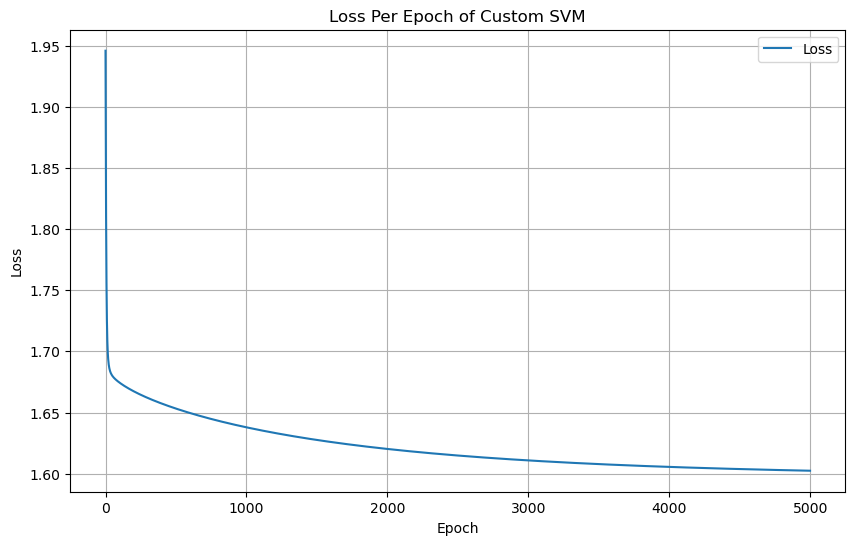

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(total_loss, label='Loss')
plt.title('Loss Per Epoch of Custom SVM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=names, zero_division=0))

Accuracy: 0.4108527131782946
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00         8
     Colin Powell       0.00      0.00      0.00        24
  Donald Rumsfeld       0.00      0.00      0.00        12
    George W Bush       0.41      1.00      0.58        53
Gerhard Schroeder       0.00      0.00      0.00        11
      Hugo Chavez       0.00      0.00      0.00         7
       Tony Blair       0.00      0.00      0.00        14

         accuracy                           0.41       129
        macro avg       0.06      0.14      0.08       129
     weighted avg       0.17      0.41      0.24       129



In [21]:
mlp = MLPClassifier(hidden_layer_sizes=num_hidden, max_iter=5000, random_state=42)
mlp.fit(train_features, y_train)
mlp_predictions = mlp.predict(test_features)

In [22]:
print(f'Accuracy: {accuracy_score(y_test, mlp_predictions)}\n')
print(classification_report(y_test, mlp_predictions, target_names=names, zero_division=0))

Accuracy: 0.27906976744186046

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00         8
     Colin Powell       0.19      0.12      0.15        24
  Donald Rumsfeld       0.17      0.17      0.17        12
    George W Bush       0.38      0.57      0.45        53
Gerhard Schroeder       0.00      0.00      0.00        11
      Hugo Chavez       0.00      0.00      0.00         7
       Tony Blair       0.10      0.07      0.08        14

         accuracy                           0.28       129
        macro avg       0.12      0.13      0.12       129
     weighted avg       0.22      0.28      0.24       129



In [23]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(train_features, y_train)
svm_predictions = svm.predict(test_features)

In [24]:
print(f'Accuracy: {accuracy_score(y_test, svm_predictions)}\n')
print(classification_report(y_test, svm_predictions, target_names=names, zero_division=0))

Accuracy: 0.4108527131782946

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00         8
     Colin Powell       0.00      0.00      0.00        24
  Donald Rumsfeld       0.00      0.00      0.00        12
    George W Bush       0.41      1.00      0.58        53
Gerhard Schroeder       0.00      0.00      0.00        11
      Hugo Chavez       0.00      0.00      0.00         7
       Tony Blair       0.00      0.00      0.00        14

         accuracy                           0.41       129
        macro avg       0.06      0.14      0.08       129
     weighted avg       0.17      0.41      0.24       129

